# ENSO Indices

## Create data-table

Here, we're looking to obtain time series for different ENSO indicators from the [NOAA database](http://www.esrl.noaa.gov/psd/data/climateindices/list/) and set them in a table for later reference. 

### Set environment

First load all the needed libraries and identify the location of the data. For plotting am using the [Seaborn Library](http://stanford.edu/~mwaskom/software/seaborn/index.html), both for the convience functions, and because I like the aesthetic. Also, to emphisise that much of this analysis is to give a general overview of the data/concepts, am opting to use a more free-sketch type [plot style](http://matplotlib.org/examples/showcase/xkcd.html). 

In [1]:
#--- Libraries
import pandas as pd               # packages for statistics
import numpy as np                # packages for linear algebra
import urllib                     # packages for accessing online data

import matplotlib.pyplot as plt   # packages for plotting
import matplotlib as mpl          # packages for plot prefrences
import seaborn as sns             # additional plotting packages

# show figures within notebook
%matplotlib inline                
plt.xkcd()

#--- Paths
url_noaa = 'http://www.esrl.noaa.gov/psd/data/correlation'

/home/tristan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


###  Download data

Now, reading the tables that are avialble online. As can be [seen](http://www.esrl.noaa.gov/psd/data/climateindices/list/), there are a many indicies availble for many different large scale climate features. Here am pulling some of the most basic ENSO related indices. 

In [2]:
#--- Define data structures
# create list of acronyms used in NOAA data base
enso_indicator = ['nina1','nina3','nina4','nina34','soi','mei']
# define time-stamps covering full range of date base
timestamps_full_range = pd.date_range(start='1/1/1948',end='12/1/2015',freq='MS')
# set data-frame to hold data
enso = pd.DataFrame(index = timestamps_full_range,columns=enso_indicator)

#--- Read data from NOAA website
# loop over available enso indicators
for index in enso_indicator :
    # open url
    link = urllib.urlopen(url_noaa+'/'+index+'.data')
    # get data
    data = link.readlines()
    # identify start year from header info
    start_year = data[0].split()[0]                  
    # identify final year from header info
    final_year = data[0].split()[1]
    # define time-stamps for range of data 
    timestamps_data = pd.date_range(start='1/1/'+start_year,
                                    end='1/12/'+final_year,
                                    freq='MS')
    # loop over years available in record
    for i in range(1,len(np.unique(timestamps_data.year))+1) :
        # define time-stamps for given year
        timestamps_current_year = pd.date_range(start='1/1/'+data[i].split()[0],
                                                end='12/1/'+data[i].split()[0],
                                                freq='MS')
        # list out data values for given year
        data_current_year = [float(x) for x in data[i].split()[1:]]
        # add data to table of index values
        enso[index][timestamps_current_year] = data_current_year



### Standardize table

Have the raw data set into a data-frame object, but would like to have some more consistancy between the time series. Here set a common notation for missing values, and normalize all the time series relative to their mean and standard deviation, so that can make direct comparisions between the data sets. Also switch the sign of the SOI index, since it is traditionally positive for a La Nina and negative for El Nino, which is the reverse of most of the SST derived indices.

In [3]:
#--- Use a common NAN indicator for all records
# find locations where use -99.99 as fill value
ind_nan = (enso == -99.99)
# relabel empty entries 
enso[ind_nan] = np.NAN

#--- Normalise time series
# create normilization function
norm = lambda x: (x - x.mean(skipna=True))/x.std(skipna=True)
# loop over each time series
for index in enso_indicator :
    # apply normalisation function to time series
    enso[index] = norm(enso[index])
    
#--- Match direction of indices
# switch sign of SOI-Index
enso['soi'] = -1*enso['soi']

#--- Tidy index names
# capitilize some names, and make acronyms all upper case
enso_indicator = map(str.capitalize,enso_indicator[0:4]) + map(str.upper,enso_indicator[4:7])
# relable SOI index to note that have changed sign
enso_indicator[4] = 'SOI (inverted)'
# set data-table columns to match edited names
enso.columns = enso_indicator

#--- Save file for future use
enso.to_pickle('data/enso_indices.pkl')

### Compare indices

In [4]:
#--- Arange data for plotting
# create column for time-stamp values
enso['Date'] = enso.index
enso = enso[enso.columns[-1:].tolist() + enso.columns[:-1].tolist()]
# set in long format
enso_melt = pd.melt(enso,id_vars='Date',value_vars=enso_indicator)
# rename indicators
enso_melt.columns = ['Date','index','value']

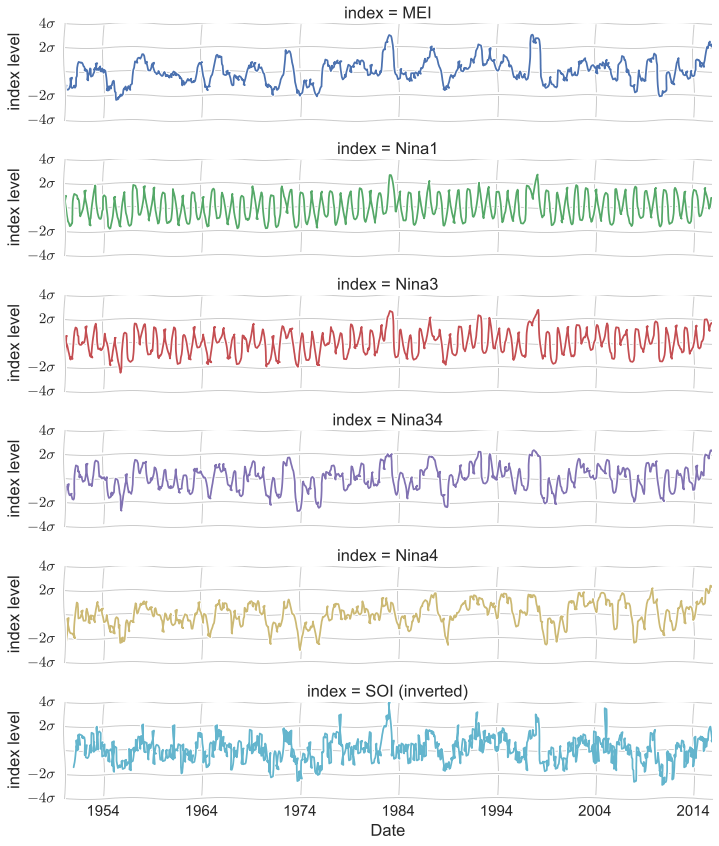

In [13]:
#--- Create graphic 
# increase font size
sns.set(font_scale=1.5)
# choose background
sns.set_style('whitegrid')
# choose color map
sns.set_palette('deep')
# set ploting data and parameters
g = sns.FacetGrid(enso_melt,row='index',hue='index',size=2,aspect=5)
# plot each index
_ = g.map(plt.plot,'Date','value')
# set position of y-axis labels
_ = g.set(yticks=[-4,-2,0,2,4])
_ = g.set_ylabels('index level')
_ = g.set_yticklabels([r'$-4\sigma$',r'$-2\sigma$','',
                       r'$2\sigma$',r'$4\sigma$'])
# save graphic as file
_ = g.savefig('various_enso_indices.png')